French Fake News Detection model with camemBERT model

This notebook contains : 
- Preparation input data
- Training camemBERT Sequence Classification (using "simpletransformers")
- Evaluation

Works on Google Colab


## Installation

In [1]:
!pip install simpletransformers

     |████████████████████████████████| 102kB 3.3MB/s 
     |████████████████████████████████| 450kB 10.6MB/s 
     |████████████████████████████████| 194kB 16.0MB/s 
     |████████████████████████████████| 860kB 20.2MB/s 
     |████████████████████████████████| 1.0MB 22.6MB/s 
  Created wheel for seqeval: filename=seqeval-0.0.12-cp36-none-any.whl size=7424 sha256=a7ddd4c049e34bf35abea717e199f09f8cf3c332e7f6f2cb3fb8742a1cdddc35
  Stored in directory: /root/.cache/pip/wheels/4f/32/0a/df3b340a82583566975377d65e724895b3fad101a3fb729f68
  Created wheel for sacremoses: filename=sacremoses-0.0.35-cp36-none-any.whl size=883999 sha256=dc2dba378c365a4b61666c795bd796f88b4e64d20ef60e5d393a9c559babfc39
  Stored in directory: /root/.cache/pip/wheels/63/2a/db/63e2909042c634ef551d0d9ac825b2b0b32dede4a6d87ddc94
Successfully built seqeval sacremoses


## Google Drive mount

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Import

In [0]:
%matplotlib inline

# for figure
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import seaborn as sns
sns.set(color_codes=True, font_scale=1.33)

# for training
from simpletransformers.classification import ClassificationModel

# to save 
import pickle
from sklearn.externals import joblib

# useful
import pandas as pd

## Definitions

In [0]:
# your data folder
PATH_FOLDER_SAVE = '/content/drive/My Drive/OpenClassRooms/IML_Projet_7/data'

PATH_DF_FAKE_NEWS = PATH_FOLDER_SAVE + '/df_fake_news.pkl'
PATH_DF_TRUE_NEWS = PATH_FOLDER_SAVE + '/df_true_news.pkl'

## Prepare Data 

In [0]:
df_true = joblib.load(PATH_DF_TRUE_NEWS)
df_fake = joblib.load(PATH_DF_FAKE_NEWS)

In [0]:
df_true = df_true.filter(items=["url", "source", "author", "title", "theme", 
                      "description", "date_published", "body"])
df_fake = df_fake.filter(items=["url", "source", "author", "title", "theme", 
                      "description", "date_published", "body"])

In [0]:
df_true["fake"] = 0
df_fake["fake"] = 1

In [0]:
df_news = pd.concat([df_true, df_fake], ignore_index=True)

In [9]:
df_news.shape

(1798, 9)

In [10]:
df_news["source"].value_counts()

LeGorafi           470
Liberation         333
Futura Sciences    317
Buzzbeed           240
Nordpresse         211
Telerama           101
Le Monde            66
Le Figaro           60
Name: source, dtype: int64

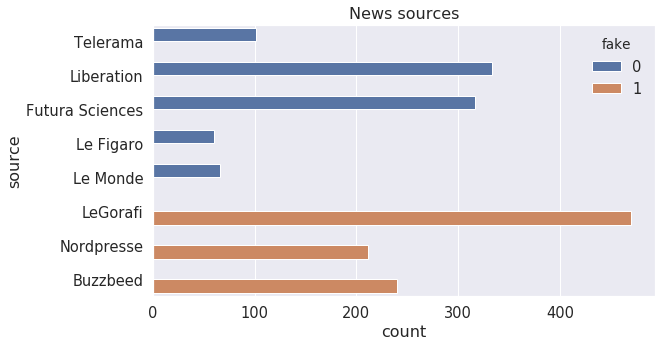

In [17]:
# Categorical bar plot with train/test
fig = plt.figure(figsize=(9, 5))
plt.title("News sources")
ax = sns.countplot(y="source", hue="fake", data=df_news)

In [0]:
# prepare in format 

##### Separate TRAIN/TEST Data

### Format data

# CamemBERT




## Test model_train sans fp16

In [0]:
from simpletransformers.classification import ClassificationModel
import pandas as pd


# Train and Evaluation data needs to be in a Pandas Dataframe of two columns. 
# The first column is the text with type str, 
# and the second column is the label with type int.
train_data = [['J aime les voyages, vacances et loisirs', 1], 
              ['Je parle de travail, boulot, expérience professionnelle', 0]]
train_df = pd.DataFrame(train_data)

eval_data = [
  ['J''aime que de loisirs', 1], 
  ['Là, on parle plutôt boulot', 0]
            ]
eval_df = pd.DataFrame(eval_data)

# Create a ClassificationModel
# You can set class weights by using the optional weight argument
model = ClassificationModel('camembert', 'camembert-base') 

# Train the model
model.train_model(train_df, 
                  args={'fp16': False, 
                        'overwrite_output_dir': True,
                        'num_train_epochs': 10})

# Evaluate the model
result, model_outputs, wrong_predictions = model.eval_model(eval_df)


/usr/local/lib/python3.6/dist-packages/simpletransformers/classification/classification_model.py:159: UserWarning: use_multiprocessing automatically disabled as CamemBERT fails when using multiprocessing for feature conversion.
  warnings.warn("use_multiprocessing automatically disabled as CamemBERT fails when using multiprocessing for feature conversion.")


Converting to features started.


Running loss: 0.639694

Running loss: 0.692853

Running loss: 0.604072

Running loss: 0.512596

Running loss: 0.385135

Running loss: 0.272847

Running loss: 0.348099

Running loss: 0.190829

Running loss: 0.127968

Running loss: 0.167333
Training of camembert model complete. Saved to outputs/.
Converting to features started.


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


In [0]:
result

{'eval_loss': 0.47185298800468445,
 'fn': 0,
 'fp': 1,
 'mcc': 0.0,
 'tn': 0,
 'tp': 1}

In [0]:
model_outputs

array([[-0.9108813 ,  0.90638113],
       [-0.09212716,  0.09879742]], dtype=float32)

In [0]:
model.args

{'adam_epsilon': 1e-08,
 'cache_dir': 'cache_dir/',
 'do_lower_case': False,
 'eval_batch_size': 8,
 'evaluate_during_training': False,
 'evaluate_during_training_steps': 2000,
 'fp16': False,
 'fp16_opt_level': 'O1',
 'gradient_accumulation_steps': 1,
 'learning_rate': 4e-05,
 'logging_steps': 50,
 'max_grad_norm': 1.0,
 'max_seq_length': 128,
 'model_name': 'camembert-base',
 'model_type': 'camembert',
 'n_gpu': 1,
 'num_train_epochs': 10,
 'output_dir': 'outputs/',
 'overwrite_output_dir': True,
 'process_count': 1,
 'reprocess_input_data': False,
 'save_steps': 2000,
 'silent': False,
 'sliding_window': False,
 'stride': 0.8,
 'tensorboard_folder': None,
 'tie_value': 1,
 'train_batch_size': 8,
 'use_multiprocessing': False,
 'warmup_ratio': 0.06,
 'warmup_steps': 1,
 'weight_decay': 0}